In [1]:
import os
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets  # transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
SMOKE_TEST = os.environ.get("SMOKE_TEST", False)

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

import glob
import tqdm
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import time
import tqdm 
import copy
from IPython.display import display, Image, clear_output
from tqdm import tqdm_notebook as tqdmn


In [3]:
camera_index = 0

cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW) # this is the magic!


In [4]:
from utils.classfier import *


In [13]:
from diffusers import StableDiffusionPipeline
import torch

# Load stable diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae=  pipe.vae
vae =  torch.compile(vae.to(device))

def decode_latents_grad(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    latents = 1 / 0.18215 * latents

    imgs = vae.decode(latents).sample

    imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def decode_latents(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    with torch.no_grad():
            latents = 1 / 0.18215 * latents

            with torch.no_grad():
                imgs = vae.decode(latents).sample

            imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def encode_imgs(imgs):
    # imgs: [B, 3, H, W]
    with torch.no_grad():
        with torch.amp.autocast(device):
            imgs = 2 * imgs - 1

            posterior = vae.encode(imgs).latent_dist
            latents = posterior.sample() * 0.18215

    return latents

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
import datetime

def save_snap(to_proj,frame):
    curr_without_sec = datetime.datetime.now().strftime("%m-%d %H:%M:%S")

    curr_without_sec = curr_without_sec.replace(" ", "_").replace(":", "_")
    
    to_proj = (to_proj * 255.0).astype(np.uint8)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # save to botorch_snapshots
    cv2.imwrite(f"botorch_snapshots/{curr_without_sec}_patch.jpg", to_proj)
    cv2.imwrite(f"botorch_snapshots/{curr_without_sec}_frame.jpg", frame)
    

In [7]:
def score_image(x):
    """The input x is an image and an expected score
    based on the CNN classifier and the scoring
    function is returned.
    """
    frames = []
    for adv_patch in x:
        to_proj = cv2.cvtColor(adv_patch.detach().cpu().float().numpy().transpose(1,2,0), cv2.COLOR_RGB2BGR)
        cv2.imshow('a',to_proj)
        cv2.waitKey(1)
        time.sleep(1)
        for ww in range(3):
            ret, frame = cap.read()
        if not ret:
            raise


        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        save_snap(to_proj,frame)


        if len(frames) != 0 and (frame != frames[-1]).sum() == 0:
            print('same frame')
            raise

        cv2.destroyAllWindows()


        frames.append(frame)


    frames = torch.cat([torch.tensor(frame).permute(2,0,1).float().cuda().unsqueeze(0) / 255 for frame in frames], dim=0).cuda()

    with torch.no_grad():
        preds = resnet_predict_raw(frames)

    preds_loss = []
    orig_clases = [817, 705, 609, 586, 436, 627, 468, 621, 803, 407, 408, 751, 717,866]
    for p in preds:
        l = 0
        for c in orig_clases:
            l += p[c]
        preds_loss.append(l)


    return torch.stack(preds_loss) * -1

In [8]:
import torchvision

In [44]:
resizer = torchvision.transforms.Resize((300, 600), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
def decode(train_x):
    with torch.no_grad():
        train_x = train_x.reshape(train_x.shape[0], 4, 4, 4)
        decoded = resizer(decode_latents(train_x).float())
    return decoded.view(train_x.shape[0], 3, 300, 600)

In [45]:
im_load = cv2.imread('./patches/out1.png')
im = cv2.cvtColor(im_load, cv2.COLOR_BGR2RGB)
resizer_32 = torchvision.transforms.Resize((32,32))
im_tensor = torch.tensor(im_load.transpose(2,0,1)).float().cuda() / 255
latent = encode_imgs(resizer_32(im_tensor).unsqueeze(0).cuda()).reshape(-1,4*4*4).cuda()


In [46]:
latent.shape

torch.Size([1, 64])

In [47]:
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms import Standardize, Normalize

d = 4*4*4

bounds = torch.tensor([[-1.0] * d, [1.0] * d], device=device, dtype=dtype)


def gen_initial_data(n=5):
    # generate training data
    # train_x = unnormalize(
    #     torch.rand(n, d, device=device, dtype=dtype),
    #     bounds=bounds
    # )
    train_x = latent + torch.randn(n, d, device=device, dtype=dtype) * 0.001
    print(train_x.shape)
    train_obj = score_image(decode(train_x)).unsqueeze(-1)
    best_observed_value = train_obj.max().item()
    return train_x, train_obj, best_observed_value


def get_fitted_model(train_x, train_obj, state_dict=None):
    # initialize and fit model
    model = SingleTaskGP(
        train_X=normalize(train_x, bounds),
        train_Y=train_obj,
        outcome_transform=Standardize(m=1)
    )
    if state_dict is not None:
        model.load_state_dict(state_dict)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    fit_gpytorch_mll(mll)
    return model

In [48]:
from botorch.optim import optimize_acqf


BATCH_SIZE = 10 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 256 if not SMOKE_TEST else 4


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a
    new candidate and a noisy observation"""

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.stack(
            [
                torch.zeros(d, dtype=dtype, device=device),
                torch.ones(d, dtype=dtype, device=device),
            ]
        ),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=bounds)
    new_obj = score_image(decode(new_x)).unsqueeze(-1)
    return new_x, new_obj

In [49]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

seed = 1
torch.manual_seed(seed)

N_BATCH = 50 if not SMOKE_TEST else 3
best_observed = []

# call helper function to initialize model
train_x, train_obj, best_value = gen_initial_data(n=5)
best_observed.append(best_value)

torch.Size([5, 64])


In [50]:
import warnings
from matplotlib import pyplot as plt
import tqdm 

warnings.filterwarnings("ignore")


print(f"\nRunning BO ", end="")

state_dict = None


Running BO 

In [51]:

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in tqdm.tqdm(range(1000)):

    # fit the model
    model = get_fitted_model(
        train_x=train_x,
        train_obj=train_obj,
        state_dict=state_dict,
    )

    # define the qNEI acquisition function
    qEI = qExpectedImprovement(
        model=model, best_f=train_obj.max()
    )

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qEI)

    # update training points
    train_x = torch.cat((train_x, new_x))
    train_obj = torch.cat((train_obj, new_obj))

    # update progress
    best_value = train_obj.max().item()
    best_observed.append(best_value)

    state_dict = model.state_dict()

    # print(".", end="")

 29%|██▊       | 286/1000 [8:45:13<21:51:13, 110.19s/it]  


KeyboardInterrupt: 

In [52]:
best_observed

[-0.31136107444763184,
 -0.3040039837360382,
 -0.28091394901275635,
 -0.28091394901275635,
 -0.28091394901275635,
 -0.28091394901275635,
 -0.28091394901275635,
 -0.28091394901275635,
 -0.28091394901275635,
 -0.28091394901275635,
 -0.28091394901275635,
 -0.28091394901275635,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,
 -0.2715049386024475,

In [53]:
train_obj.argmax()

tensor(2506, device='cuda:0')

In [54]:
dec= decode(train_x[train_obj.argmax().unsqueeze(0)])

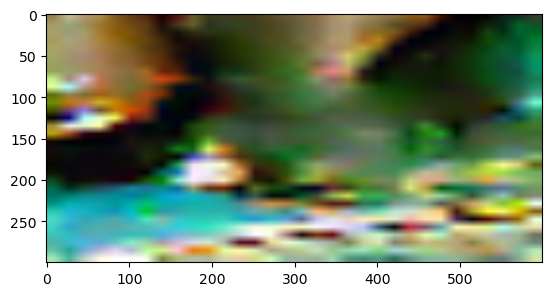

In [55]:
plt.imshow(dec[0].permute(1,2,0).cpu().numpy())

In [56]:
adv_patch = dec[0].cuda()
cv2.imshow('a',cv2.cvtColor(adv_patch.detach().cpu().float().numpy().transpose(1,2,0), cv2.COLOR_RGB2BGR))
cv2.waitKey(1)
time.sleep(10)
for ww in range(3):
    ret, frame = cap.read()
if not ret:
    raise
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

cv2.destroyAllWindows()


In [57]:
cv2.destroyAllWindows()


In [58]:
frame_tensor = torch.tensor(frame).permute(2,0,1).float().cuda().unsqueeze(0) / 255

In [59]:
resnet_predict(frame_tensor)

'jeep: 0.109%'

In [46]:
list(zip(weights.meta["categories"], np.arange(len(weights.meta["categories"]))))

[('tench', 0),
 ('goldfish', 1),
 ('great white shark', 2),
 ('tiger shark', 3),
 ('hammerhead', 4),
 ('electric ray', 5),
 ('stingray', 6),
 ('cock', 7),
 ('hen', 8),
 ('ostrich', 9),
 ('brambling', 10),
 ('goldfinch', 11),
 ('house finch', 12),
 ('junco', 13),
 ('indigo bunting', 14),
 ('robin', 15),
 ('bulbul', 16),
 ('jay', 17),
 ('magpie', 18),
 ('chickadee', 19),
 ('water ouzel', 20),
 ('kite', 21),
 ('bald eagle', 22),
 ('vulture', 23),
 ('great grey owl', 24),
 ('European fire salamander', 25),
 ('common newt', 26),
 ('eft', 27),
 ('spotted salamander', 28),
 ('axolotl', 29),
 ('bullfrog', 30),
 ('tree frog', 31),
 ('tailed frog', 32),
 ('loggerhead', 33),
 ('leatherback turtle', 34),
 ('mud turtle', 35),
 ('terrapin', 36),
 ('box turtle', 37),
 ('banded gecko', 38),
 ('common iguana', 39),
 ('American chameleon', 40),
 ('whiptail', 41),
 ('agama', 42),
 ('frilled lizard', 43),
 ('alligator lizard', 44),
 ('Gila monster', 45),
 ('green lizard', 46),
 ('African chameleon', 47),


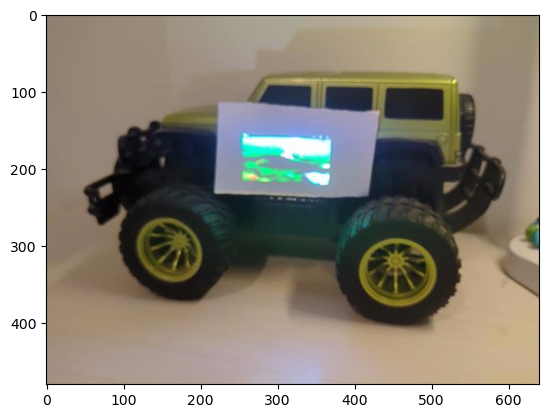

In [42]:
plt.imshow(frame)

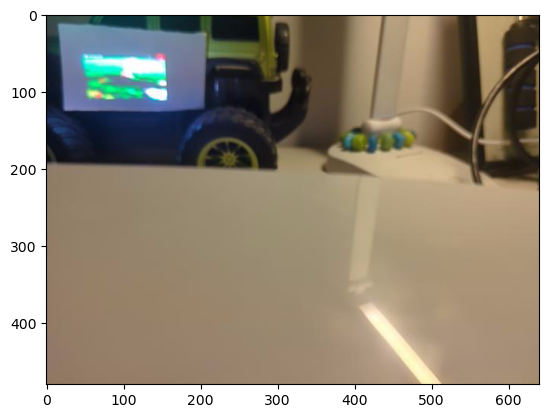

In [99]:
plt.imshow(frame)

In [ ]:
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline


fig, ax = plt.subplots(1, 6, figsize=(14, 14))
percentages = np.array([0, 10, 25, 50, 75, 100], dtype=np.float32)
inds = (N_BATCH * BATCH_SIZE * percentages / 100 + 4).astype(int)

for i, ax in enumerate(ax.flat):
    b = torch.argmax(score_image(decode(train_x[: inds[i], :])), dim=0)
    img = decode(train_x[b].view(1, -1)).squeeze().cpu()
    ax.imshow(img, alpha=0.8, cmap="gray")

In [47]:
import glob

In [49]:
patches_dir = './botorch_snapshots'

In [61]:
patchs = glob.glob(os.path.join(patches_dir, '*_frame.jpg'))

In [62]:
import pickle
dump_dir = './dump_for_train/'

with open(dump_dir + 'H.pickle','rb') as f:
    H = pickle.load(f)

In [63]:
with open(dump_dir + 'orig_ref_frame.pickle','rb') as f:
    orig_ref_frame = pickle.load(f)

In [64]:
import pickle
from torchvision import transforms
import matplotlib.pyplot as plt
tt = transforms.ToTensor()
# load data from calibration
# with open('./calibration_dump/calibration4.pickle','rb') as f:
#     H = pickle.load(f)
# with open('./calibration_dump/orig_ref_frame4.pickle','rb') as f:
#     orig_ref_frame = pickle.load(f)

from torchvision import transforms

tt = transforms.ToTensor()

import torch 
import kornia
H_t = torch.tensor(H).float().unsqueeze(0).cuda()
def warp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t, (orig_ref_frame.shape[0], orig_ref_frame.shape[1]))


In [65]:

H_t_i = H_t.inverse()
def unwarp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t_i , (300,600))

In [88]:
# plt.imshow(cv2.cvtColor(cv2.imread(patchs[0]),cv2.COLOR_BGR2RGB)/255)

In [91]:
import tqdm

In [93]:
for patch in tqdm.tqdm(patchs):
    img = cv2.cvtColor(cv2.imread(patch),cv2.COLOR_BGR2RGB)/255
    img = tt(img).unsqueeze(0).cuda().float()
    un = unwarp(img)
    un = un.squeeze().cpu().detach().numpy().transpose(1,2,0) * 255.0
    un = un.astype(np.uint8)
    un = cv2.cvtColor(un, cv2.COLOR_RGB2BGR)
    cv2.imwrite(patch.replace('_frame.jpg','_frame_aug.jpg'), un)



100%|██████████| 3495/3495 [03:45<00:00, 15.51it/s]


'./botorch_snapshots\\04-05_21_30_34_frame.jpg'

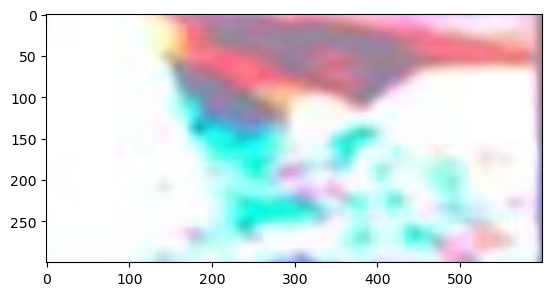

In [87]:
plt.imshow(un[0].permute(1,2,0).cpu().numpy())
